<a id="top"></a>

Table of contents

- [Importing packages](#package)
- [Reading Airbnb dataset](#dataset)
- [Defining helper functions](#function)
- [Exploring the data](#explore)
- [Main body](#main)    

<a id="package"></a>
## Importing packages

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
from zipfile import ZipFile

from datetime import datetime

In [2]:
# Matplotlib axis formatter
from matplotlib.axis import Axis   
import matplotlib.ticker as ticker 

In [3]:
# Geopandas package
import geopandas as gpd
from shapely.geometry import Point, Polygon
import descartes

<a id="dataset"></a>
## Reading Airbnb dataset

In [4]:
DATA_PATH = os.path.join(os.getcwd(), 'data')
FILE_PATH_SEATTLE = os.path.join(DATA_PATH, 'seattle.zip')
FILE_PATH_BOSTON = os.path.join(DATA_PATH, 'boston.zip')

In [5]:
def extract_df_from_airbnb_zipfile(PATH_ZIPFILE) :
    '''
        INPUT : file path to a zipfile to open
        OUTPUT : a dictionary that contains dataframes of files 
        extracted from the zip file
    '''

    zf = ZipFile(PATH_ZIPFILE) 
    dfs = {
        text_file.filename : pd.read_csv(zf.open(text_file.filename ))
        for text_file in zf.infolist() 
        if text_file.filename.endswith('.csv')
    }
    
    print('Printing a dictionary with filenames as keys')
    for filename in dfs.keys() :
        print(f'Filename (keys): {filename}')
    
    return dfs

In [6]:
dfs_sea = extract_df_from_airbnb_zipfile(FILE_PATH_SEATTLE)

Printing a dictionary with filenames as keys
Filename (keys): calendar.csv
Filename (keys): listings.csv
Filename (keys): reviews.csv


In [7]:
listings_sea = dfs_sea['listings.csv']
reviews_sea = dfs_sea['reviews.csv']
calendar_sea = dfs_sea['calendar.csv']

---
<a id="function"></a>
## Defining helper functions
Collect all functions to use in this notebook.

In [8]:
# Helper function
def convert_str_to_datetime(df, date_feature) :

    date_conversion = lambda x : datetime.strptime(x, "%Y-%m-%d")
    
    return df[date_feature].apply(date_conversion)
    

def break_date(df, date_feature) :

    df_new = df.copy()
    
    df_new[date_feature] = convert_str_to_datetime(df_new, date_feature)

    df_new['year'] = df_new[date_feature].apply(lambda x : x.year)
    df_new['month'] = df_new[date_feature].apply(lambda x : x.month)
    df_new['day'] = df_new[date_feature].apply(lambda x : x.day)
    
    return df_new
    

In [9]:
def convert_price_float(series) :

    # Remove $ & , sign from price
    rep = {'$':'', ',': ''}

    for old, new in rep.items() :
        series = series.str.replace(old, new)
        
    # convert date type to float
    series = series.astype(float)
    
    return series

In [10]:
def convert_binary_num(series) :
    
    series = series.map({
        't': 1, 'f':0
    })
    
    return series

In [11]:
def plot_line_chart(x, height, layout_obj=False, rotation=False) :

    if ( layout_obj ) and ( not len(layout_obj) == 3 ): 
        print('Length of layout_obj must be 3')
        raise 
    
    title, xlabel, ylabel = layout_obj.values()
    
    plt.figure(figsize=(10,4))
    plt.plot(x, height, marker='o')

    plt.title(title)
    plt.xlabel(xlabel);
    plt.ylabel(ylabel)
    plt.axhline(height.mean(), c='orange', ls='--')
    
    if rotation : 
        plt.xticks(rotation=45);

    plt.show()

In [12]:
def plot_bar_chart(x, height, layout_obj=False, rotation=False) :

    if ( layout_obj ) and ( not len(layout_obj) == 3 ): 
        print('Length of layout_obj must be 3')
        raise 
    
    title, xlabel, ylabel = layout_obj.values()
    
    plt.figure(figsize=(10,4))
    plt.bar(x, height)

    plt.title(title)
    plt.xlabel(xlabel);
    plt.ylabel(ylabel)
    
    if rotation : 
        plt.xticks(rotation=45);

    plt.show()

In [13]:
def map_calendar_month(series) :
    
    try : 
        series = series.map({
            1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
            7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'
        })
        
        return series
        
    except :
        print('Failed mapping')
        return

In [14]:
def create_points_geometry(series1, series2) :
    """ Create points from longitude, latitude data 
    using GeoPandas module    
        
    arg: 
        series1 : longitude data series
        series2 : latitude data series
        
    return: 
        transformed geometry list which will be used 
        as a parameter of GeoDataFrame
    """
    
    return [Point(xy) for xy in zip(series1, series2)]
    

[Go to the bottom](#bottom)

---
<a id="explore"></a>
## Exploring the data
The respective Airbnb datasets are downloaded from : 

- Seattle : https://www.kaggle.com/airbnb/seattle
- Boston  : https://www.kaggle.com/airbnb/boston



### Content
- Listings, including full descriptions and average review score
- Review, including unique id for each reviewer and detailed comments
- Calendar, including listing id and the price and availability for that day

### Inspiration
- Can you describe the vibe of each Seattle neighborhood using listing descriptions?
- What are the busiest times of the year to visit Seattle? By how much do prices spike?
- Is there a general upward trend of both new Airbnb listings and total Airbnb visitors to Seattle?

Reference to the real use of the data: http://insideairbnb.com/seattle/

<a id="main"></a>
## `1.` Occupancy rate & price through the year
Working with **`calendar`** dataframe for both Seattle and Boston airbnb dataset. I will work on Seattle data first and subsequently apply a function for wrangling and visualizing Boston data.

### Data cleaning & exploration

In [15]:
# Copy a dataframe for data cleaning
calendar = calendar_sea.copy() 

In [16]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In [17]:
# Data for 365 days from 2016-01-04 - 2017-01-02
len(calendar.date.value_counts().index) 

365

In [18]:
# Convert t, f to binary int : available
calendar.available = convert_binary_num(calendar.available)

In [19]:
# Remove $ & , sign from price
calendar.price = convert_price_float(calendar.price)

In [20]:
# Occpancy rate and price per day 
occ_price_tbl= calendar.groupby('date').mean().drop(columns='listing_id')
occ_price_tbl.columns = ['occ_rate', 'avg_rate']
occ_price_tbl.describe()

,occ_rate,avg_rate
count,365.000000,365.000000
mean,0.670610,137.901783
std,0.047899,9.860142
min,0.454426,117.685413
25%,0.647197,132.446443
50%,0.674961,136.731206
75%,0.702462,146.930502
max,0.765322,157.480000


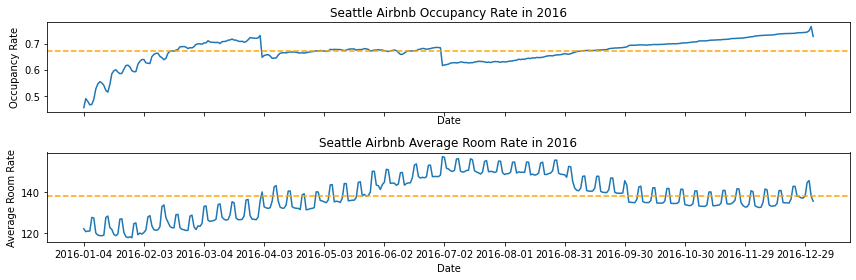

In [21]:
ticks = np.arange(0, len(occ_price_tbl.index)+1, 30)
labels = [occ_price_tbl.index[idx] for idx in ticks]

date = occ_price_tbl.index
rate_dict = [{'data': occ_price_tbl.occ_rate, 'desc': 'Occupancy Rate'},
             {'data': occ_price_tbl.avg_rate, 'desc': 'Average Room Rate'}]

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12,4))

for i in [0, 1] : 
    axes[i].plot(date, rate_dict[i]['data'])
    axes[i].set_title('Seattle Airbnb ' + rate_dict[i]['desc'] + ' in 2016')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(rate_dict[i]['desc'])
    axes[i].set_xticks(labels) 
    axes[i].axhline(rate_dict[i]['data'].mean(), ls='--', color='orange', lw=1.5)
    
    fig.tight_layout()

plt.show()

In Seattle, the occupancy rate starts to increase from the beginning of 2016 until its first peak around early-April. It suddenly dips right after the April peak and stays idle until its second dip on early July. After that the trend starts to rise until the end of the year. 

When it comes to average room rate, it starts to increase from the beginning of the year until its peak near July. The room rate stays in the highest level for nearly 2 months until it slowly decreases and remains on the average level. 

Next, I will break the dates down into year, month and day for more detailed analysis.

### Converting date from string to datetime object

In [22]:
# Convert into datetime object : date
date_conversion = lambda x : datetime.strptime(x, "%Y-%m-%d")
calendar.date = calendar.date.apply(date_conversion)

In [23]:
calendar.insert(2, 'year', calendar.date.apply(lambda x : x.year))
calendar.insert(3, 'month', calendar.date.apply(lambda x : x.month))
calendar.insert(4, 'day', calendar.date.apply(lambda x : x.day))

<font color='#d9534f'>The above codes take too much time, which will be improved for any later use with `break_date` function</font>

### Trend of Occupancy rate and average room rate in 2016
Monthly, Airbnb Seattle

In [24]:
analysis_seattle = calendar.groupby('month').mean()[['available', 'price']]
analysis_seattle.head()

,available,price
month,,
1,0.566937,122.912176
2,0.662208,124.293927
3,0.709187,128.644488
4,0.663847,135.097005
5,0.675670,139.538183


In [25]:
# Mapping integers to month name
analysis_seattle.index = map_calendar_month(analysis_seattle.index)

# Change column names
analysis_seattle.columns = ['occ_rate', 'room_rate']

# Confirm the change
analysis_seattle.head()

,occ_rate,room_rate
month,,
Jan,0.566937,122.912176
Feb,0.662208,124.293927
Mar,0.709187,128.644488
Apr,0.663847,135.097005
May,0.675670,139.538183


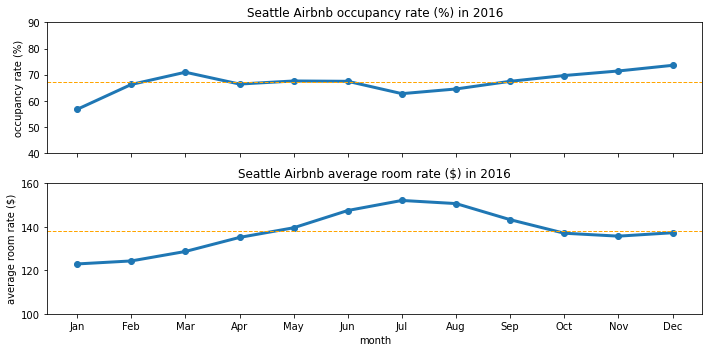

In [26]:
date = analysis_seattle.index
rate_dict = [{'data': analysis_seattle.occ_rate, 'desc': 'occupancy rate (%)'},
             {'data': analysis_seattle.room_rate, 'desc': 'average room rate ($)'}]

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 5))

for i in [0, 1] : 
    axes[i].plot(date, rate_dict[i]['data'], marker='o', lw=3)
    axes[i].set_title('Seattle Airbnb ' + rate_dict[i]['desc'] + ' in 2016')
    axes[i].set_ylabel(rate_dict[i]['desc'])
    axes[i].axhline(rate_dict[i]['data'].mean(), ls='--', color='orange', lw=1)


axes[1].set_xlabel('month')    
fig.tight_layout()

axes[0].set_yticks(np.arange(0.4, 0.8 + 0.2, 0.1))
axes[0].set_yticklabels([str(occ) for occ in range(40, 80 + 20, 10)])

axes[1].set_yticks(np.arange(100, 160 + 20, 20))
axes[1].set_yticklabels([str(price) for price in range(100, 160 + 20, 20)])

plt.show()

The occupancy rate starts with the lowest level below 60% in the beginning of the year, and follows the increasing trend until March. As seen previously, there was a sudden dip April, which took effect in the occupancy rate in that month. The occupancy rate in July stays below the year's average level and it continues on in August. However, it gets recovered until its peak in December. 

Average room rates peak up in the summer period from Jun to August, whilst the higher price level may explain the lower occupancy level during the same period. However, is it good or bad? It is hard to see the performance by seperating the occupany rate and average room rate, and there is a metric that the hotel industry uses to measure the business performance, called RevPar.

 ### How about RevPar ? 

RevPAR, or revenue per available room, is a performance metric in the hotel industry that is calculated by dividing a hotel's total guestroom revenue by the room count and the number of days in the period being measured. https://en.wikipedia.org/wiki/RevPAR

It can alternatively be calculated as $occupancy rate (# room occupied / # available) x average room rate$.

In [27]:
analysis_seattle['revpar'] = ( analysis_seattle.occ_rate 
                                * analysis_seattle.room_rate )

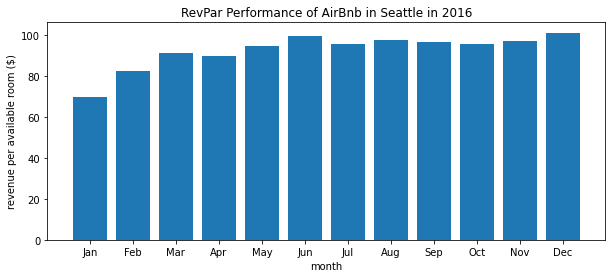

In [28]:
date = analysis_seattle.index
revpar = analysis_seattle['revpar']
layout_obj = {
    'title': 'RevPar Performance of AirBnb in Seattle in 2016',
    'xlabel': 'month',
    'ylabel': 'revenue per available room ($)'
}

plot_bar_chart(date, revpar, layout_obj, rotation=False)

plt.show()

In [29]:
analysis_seattle['revpar'].sort_values(ascending=False)

month
Dec    100.958803
Jun     99.453597
Aug     97.181255
Nov     96.879911
Sep     96.612092
Oct     95.444659
Jul     95.377854
May     94.281823
Mar     91.233047
Apr     89.683700
Feb     82.308439
Jan     69.683499
Name: revpar, dtype: float64

The RevPar is \\$99.45 in June, which is the second highest level through the year. It looks that the decrease in occupancy rate in August affected the RevPar but the performance in August is not too bad with \\$97.18. 

RevPar performance is quite steady from Q3 onwards, but a further study seems necessary to figure out why it started low in the beginning of the year. Supposedly there was a series of concerns around Airbnb that may have affected the confidence from consumer and hosts, as following:

- Concerns over the company's affecting the local housing market affordability and some political consideration were expected whether to regulate the company's activity: [source1](https://www.seattletimes.com/business/airbnb-says-its-rentals-arent-affecting-housing-affordability/) [source2](https://www.geekwire.com/2016/seattle-regulates-airbnb-company-releases-study-showing-178m-annual-impact-local-economy/)

- Airbnb will start collecting taxes in Washington state: [source](https://www.geekwire.com/2015/airbnb-will-start-collecting-taxes-in-washington-state-on-behalf-of-hosts)

---
## Extend the analysis to Boston data

### Get Boston data

In [30]:
# Extract airbnb Boston 'calendar' data
df_bos = extract_df_from_airbnb_zipfile(FILE_PATH_BOSTON)

Printing a dictionary with filenames as keys
Filename (keys): calendar.csv
Filename (keys): listings.csv
Filename (keys): reviews.csv


In [31]:
calendar_bos = df_bos['calendar.csv']
listings_bos = df_bos['listings.csv']
reviews_bos = df_bos['reviews.csv']

### Date seems not consistent across the dataset!

In [32]:
calendar_bos.date.sort_values() # Boston calendar data starts from 2016-09-06

654444     2016-09-06
440919     2016-09-06
440554     2016-09-06
440189     2016-09-06
439824     2016-09-06
              ...    
1218735    2017-09-05
425513     2017-09-05
734628     2017-09-05
1048645    2017-09-05
0          2017-09-05
Name: date, Length: 1308890, dtype: object

In [33]:
calendar_sea.date.sort_values()

0          2016-01-04
1171285    2016-01-04
442380     2016-01-04
997180     2016-01-04
1203040    2016-01-04
              ...    
924544     2017-01-02
924179     2017-01-02
923814     2017-01-02
928194     2017-01-02
1393569    2017-01-02
Name: date, Length: 1393570, dtype: object

There is an issue in date consistency between Seattle and Boston calendar data. Boston calendar data has a date range from 2016-09-06 to 2017-09-05, whereas Seattle data is for the period between 2016-01-04 and 2017-01-02.

Therefore it is not a good idea to compare the two cities' performances by monthly.

### Apply wrangling functions to both Seattle and Boston dataframes

In [38]:
def get_analysis_table(df) : 

    # Convert t, f to binary int : available
    df.available = convert_binary_num(df.available)
    # Remove $ & , sign from price
    df.price = convert_price_float(df.price)
    # Occpancy rate and price per day 
    
    table = df.groupby('date').mean().drop(columns='listing_id')
    table.columns = ['occ_rate', 'avg_room_rate'] # daily

    table['revpar'] = table['occ_rate'] * table['avg_room_rate']

    return table

In [39]:
analysis_seattle = get_analysis_table(calendar_sea.copy())
analysis_boston = get_analysis_table(calendar_bos.copy())

### Comparison between Seattle and Boston
The transformed data shows daily average.

Terminology used: 
- Occupancy rate : # rooms rented out / # total available rooms on a given day
- Average room rate : average price of available rooms on a given day
- Revpar : Occupancy rate x Average room rate, which is an aggregated meature to evaluate rental performance

### Occupancy rate

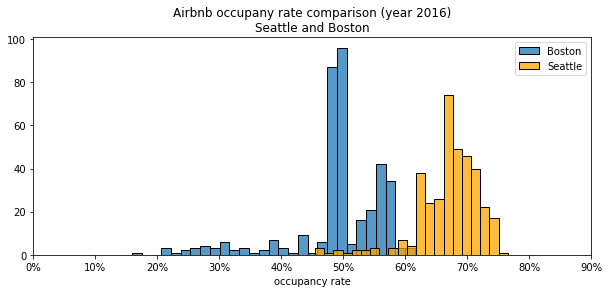

In [40]:
title = 'Airbnb occupany rate comparison (year 2016)\nSeattle and Boston'
xlabel = 'occupancy rate'
ylabel = ''

fig, ax = plt.subplots(figsize=(10,4))
ax = sns.histplot(analysis_boston['occ_rate'], label='Boston')
sns.histplot(analysis_seattle['occ_rate'], ax=ax, color='orange', label='Seattle');

ax.set(xlabel=xlabel, ylabel=ylabel, title=title);
ax.set_xticks(np.arange(0, 1, 0.1))
ax.set_xticklabels(f'{i}%' for i in np.arange(0, 100, 10))

plt.legend()
plt.show()

### Room rate

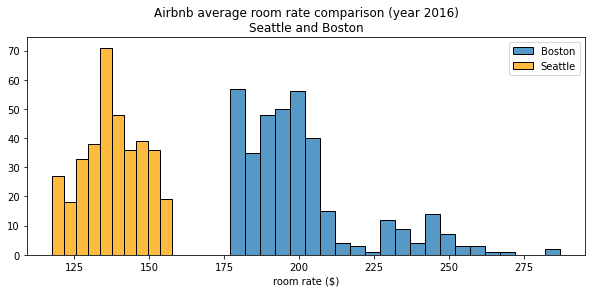

In [41]:
title = 'Airbnb average room rate comparison (year 2016)\nSeattle and Boston'
xlabel = 'room rate ($)'
ylabel = ''

fig, ax = plt.subplots(figsize=(10,4))
ax = sns.histplot(analysis_boston['avg_room_rate'], label='Boston')
sns.histplot(analysis_seattle['avg_room_rate'], ax=ax, color='orange', label='Seattle');

ax.set(xlabel=xlabel, ylabel=ylabel, title=title);

plt.legend()
plt.show()

### RevPar

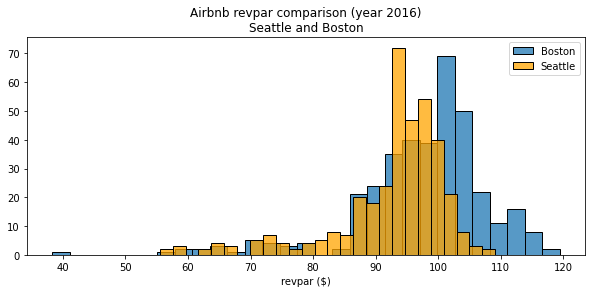

In [43]:
title = 'Airbnb revpar comparison (year 2016)\nSeattle and Boston'
xlabel = 'revpar ($)'
ylabel = ''

fig, ax = plt.subplots(figsize=(10,4))
ax = sns.histplot(analysis_boston['revpar'], label='Boston')
sns.histplot(analysis_seattle['revpar'], ax=ax, color='orange', label='Seattle');

ax.set(xlabel=xlabel, ylabel=ylabel, title=title);

plt.legend()
plt.show()

In [52]:
print(f'SEATTLE:\n{analysis_seattle.describe()}')
print()
print(f'BOSTON:\n{analysis_boston.describe()}')

SEATTLE:
         occ_rate  avg_room_rate      revpar
count  365.000000     365.000000  365.000000
mean     0.670610     137.901783   92.507204
std      0.047899       9.860142    9.165813
min      0.454426     117.685413   55.479047
25%      0.647197     132.446443   90.289419
50%      0.674961     136.731206   94.582504
75%      0.702462     146.930502   97.844421
max      0.765322     157.480000  109.101886

BOSTON:
         occ_rate  avg_room_rate      revpar
count  365.000000     365.000000  365.000000
mean     0.491284     201.165200   97.489904
std      0.076196      20.989130   10.679226
min      0.158951     177.023002   38.314278
25%      0.484663     186.764936   92.868935
50%      0.493865     196.100469   99.741495
75%      0.542666     205.207474  103.198550
max      0.615449     286.921977  119.380926


Overall, revpar performance is better in Boston than in Seattle. Although occupancy rate in Seattle is more stable (by standard deviation) and higher (67%, median) on average, the difference of average room rate between the two cities is larger.

---
## `2`. Trend in listing

<br>

<font color="orangered">Earlier we saw the first quarater revpar performance in Seattle is low, due to both occupancy rate and revpar below the average level.</font> To gain a better insight, I would like to explore how the supply side reacted during the same period.


Discovering the supply side, particularly in the following areas:

- \# of new hostings : `host_since`, `calculated_host_listings_count`
- number of super_host : `host_is_superhost`
- hosting type: [`property_type`, `room_type`, `price`, ...]

In [53]:
# Copy a dataframe for data cleaning
listings = listings_sea.copy() 
listings.shape

(3818, 92)

In [54]:
cols_host = listings.loc[:, listings.columns.str.contains('host')]
extra_info = listings[['property_type', 'room_type', 'price']]

host_original = cols_host.join(extra_info)
print(host_original.shape)
host_original.head()

(3818, 22)


,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,...,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,calculated_host_listings_count,property_type,room_type,price
0,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,2,Apartment,Entire home/apt,$85.00
1,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,6,Apartment,Entire home/apt,$150.00
2,16708587,https://www.airbnb.com/users/show/16708587,Jill,2014-06-12,"Seattle, Washington, United States",i love living in Seattle. i grew up in the mi...,within a few hours,67%,100%,f,...,Queen Anne,2.0,2.0,"['email', 'phone', 'google', 'reviews', 'jumio']",t,t,2,House,Entire home/apt,$975.00
3,9851441,https://www.airbnb.com/users/show/9851441,Emily,2013-11-06,"Seattle, Washington, United States",NaN,NaN,NaN,NaN,f,...,Queen Anne,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,1,Apartment,Entire home/apt,$100.00
4,1452570,https://www.airbnb.com/users/show/1452570,Emily,2011-11-29,"Seattle, Washington, United States","Hi, I live in Seattle, Washington but I'm orig...",within an hour,100%,NaN,f,...,Queen Anne,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,1,House,Entire home/apt,$450.00


### Data cleaning

#### Drop unnessary / repetitive features
return host_clean_v0 dataframe

In [55]:
# drop unnecessary cols
# calculated_host_listings_count are more accurate info
drop_cols = ['host_url', 'host_thumbnail_url', 'host_picture_url', 'host_verifications',
             'host_has_profile_pic', 'host_listings_count', 'host_total_listings_count']
host_clean_v0 = host_original.drop(columns = drop_cols).copy()

In [56]:
#pd.options.display.max_row = None
#host[host.duplicated(subset=['host_id'], keep=False)].sort_values(by='host_id')

#### Drop duplicates

It looks that host_id is duplicated when a host has more than 1 hosting. Drop duplicates by host_id (not host_name!). 72% remain after removing duplicated rows, but it is rational to drop, and keep the last row (latest).

return host_clean_v1 dataframe

In [57]:
( host_clean_v0.drop_duplicates(subset=['host_id'], keep='last').shape[0] 
 / host_clean_v0.shape[0] )

0.7205343111576742

- There are rows with no information, which is to be removed. 
- `host_since` feature needs conversion to date time object. 

In [58]:
# Drop duplicates
host_clean_v1 = host_clean_v0.drop_duplicates(subset=['host_id'], keep='last')

#### Drop missing values

return host_clean_v2 dataframe

In [59]:
# Drop 2 missing values
host_clean_v1[host_clean_v1['host_since'].isnull()]

,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_identity_verified,calculated_host_listings_count,property_type,room_type,price
1297,42515980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Apartment,Entire home/apt,$99.00
1419,1075031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Apartment,Entire home/apt,$250.00


In [60]:
host_clean_v2 = host_clean_v1[host_clean_v1['host_since'].notnull()]

#### Change to relevant data type
return host_clean_v3 dataframe

In [61]:
# Convert into date time object
print(host_clean_v2.shape)
host_clean_v3 = break_date(host_clean_v2, 'host_since')

(2749, 15)


In [62]:
print(host_clean_v3.shape) 
#host_clean_v3.info()
#host_clean_v3.head()

(2749, 18)


In [63]:
host = host_clean_v3

---
### Create a function for wrangling
Checked if seattle and boston dataframe share all features in common : there are three features that Seattle listings dataset do not have, which however are not relevant for this analysis.

In [64]:
#listings_bos.columns.isin(listings_sea.columns)
listings_bos.columns[12:15]

Index(['access', 'interaction', 'house_rules'], dtype='object')

In [65]:
def wrangle_airbnb_host_data(df) :
    
    # Check if input dataframe is 'listings' dataset
    # Three three key columns must be inside the dataframe
    key_cols= ['host_id', 'host_since', 'calculated_host_listings_count']
    
    if df.columns.isin(key_cols).sum() !=3 :
        print('Check if input dataframe is correct or data format has been changed')
        return 
    
    print(f'Original dataframe has {df.shape[0]} x {df.shape[1]} dataset')
    
    df_copy = df.copy()
    
    # Drop uncessary columns
    host_related  = df.loc[:, df.columns.str.contains('host')]
    extra_info = df[['property_type', 'room_type', 'price']]
    
    host_df = host_related.join(extra_info)
    drop_cols = ['host_url', 'host_thumbnail_url', 'host_picture_url', 'host_verifications',
                 'host_has_profile_pic', 'host_listings_count', 'host_total_listings_count']
    host_df = host_df.drop(columns = drop_cols)
    
    # Drop duplicates
    host_df = host_df.drop_duplicates(subset=['host_id'], keep='last')
    
    # Drop null 
    host_df = host_df[host_df['host_since'].notnull()]
    
    # Convert into date time object
    host_df = break_date(host_df, 'host_since')
    
    
    print(f'After wrangling : returning {host_df.shape[0]} x {host_df.shape[1]} dataset')
    
    return host_df
    

In [66]:
host_seattle = wrangle_airbnb_host_data(listings_sea)
host_boston = wrangle_airbnb_host_data(listings_bos)

Original dataframe has 3818 x 92 dataset
After wrangling : returning 2749 x 18 dataset
Original dataframe has 3585 x 95 dataset
After wrangling : returning 2181 x 18 dataset


### How has number of hosing grown year on year?

In [67]:
new_hosting_seattle = host_seattle.groupby('year').count()['host_id']
new_hosting_boston = host_boston.groupby('year').count()['host_id']

In [68]:
analysis_new_hostings = pd.concat([new_hosting_seattle.rename('new_hosting_seattle'), 
                                   new_hosting_boston.rename('new_hosting_boston')], axis=1)

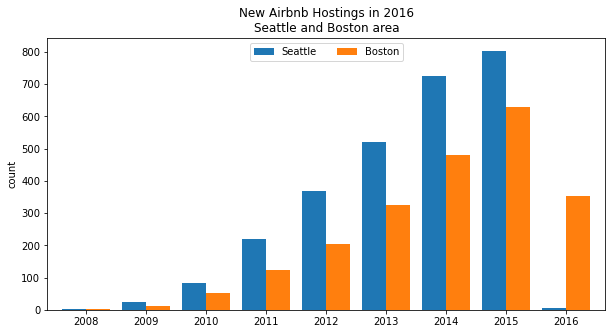

In [102]:
analysis_new_hostings.plot.bar(figsize=(10,5), width=0.8)

plt.title('New Airbnb Hostings in 2016\nSeattle and Boston area')
plt.xlabel('')
plt.ylabel('count')
plt.xticks(rotation=0)
plt.legend(labels=['Seattle', 'Boston'], loc='upper center', ncol=6)

plt.show()

The joining of new hosts has been growing rapidly (can say exponentially) since the establishment of Airbnb (2008) in both Seattle and Boston markets. The number of new hostings is larger in Seattle than Boston - may possibly be due to lots of reasons i.e. more favourable regulation, demographic, market acitivities, etc. 

However, the new hostings became significantly idle in 2016 for both Seattle and Boston markets. This may be resulted from error in data collection but assuming data is super reliable, new regulatatory move and tax policy may have made potential hosts to be more cautious in renting out their properties in Seattle as considered earlier during revpar analysis (resources can be found as below).

- Concerns over the company's affecting the local housing market affordability and some political consideration were expected whether to regulate the company's activity: [source1](https://www.seattletimes.com/business/airbnb-says-its-rentals-arent-affecting-housing-affordability/) [source2](https://www.geekwire.com/2016/seattle-regulates-airbnb-company-releases-study-showing-178m-annual-impact-local-economy/)

- Airbnb will start collecting taxes in Washington state: [source](https://www.geekwire.com/2015/airbnb-will-start-collecting-taxes-in-washington-state-on-behalf-of-hosts)

### General hosting statistics 
To gain insights into hostings : `superhost`, `property_type`, `room_type`, `price`

### How much percentage superhost accounts for?

In [132]:
is_superhost_sea = host_seattle.host_is_superhost.value_counts()
is_superhost_bos = host_boston.host_is_superhost.value_counts()

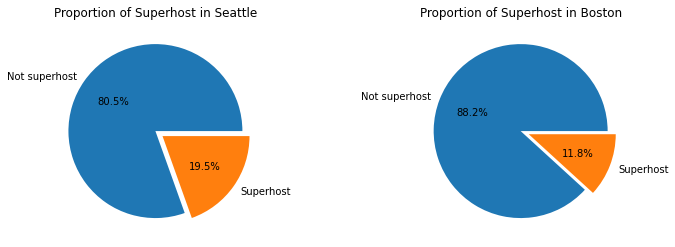

In [133]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,4))

ax1.pie(is_superhost_sea, labels=['Not superhost', 'Superhost'], autopct='%1.1f%%', explode=(0, 0.1))
ax2.pie(is_superhost_bos, labels=['Not superhost', 'Superhost'], autopct='%1.1f%%', explode=(0, 0.1))

ax1.set_title(f'Proportion of Superhost in Seattle')
ax2.set_title(f'Proportion of Superhost in Boston')

plt.show()

**Terminology:**

According to Aibnb, "Superhosts are experienced hosts who provide a shining example for other hosts, and extraordinary experiences for their guests." [Reference](https://www.airbnb.com/help/article/828/what-is-a-superhost)

To retain Superhost status, hosts should satisfies the performance standards and other qualifications for the most recent 12 months from the review date. This suggests that superhosts represent dedicated property suppliers in a fairly consistent manner. Source at the link [here]((https://www.airbnb.com/superhost/terms)

**Findings:**

Nearly 20% of the total hostings are made by Superhost in Seattle as opposed to 12% in Boston. It suggests that overall rental room supply is more consistent and stable in Seattle with more dedicated property owners. On the other hand, it may also be a barrier to entry for potential hosts facing stornger competitions already existing.

Whether this affected the sudden decrease in new listings in 2016 is not so obvious, and leaves a room for a further analysis, which however will not be covered in this notebook.

### Property type

In [134]:
property_type_seattle = host_seattle.property_type.value_counts()
property_type_boston = host_boston.property_type.value_counts()

<ipython-input-135-f73adbee5489>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(property_type_seattle.index, rotation=90)


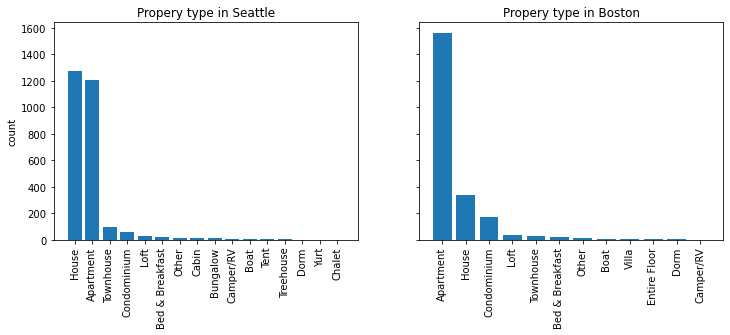

In [135]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,4))

ax1.bar(property_type_seattle.index, property_type_seattle.values)
ax2.bar(property_type_boston.index, property_type_boston.values)

ax1.set_title(f'Propery type in Seattle')
ax2.set_title(f'Propery type in Boston')
ax1.set_ylabel('count')

# Two different ways to set xticks in subplot
ax1.set_xticklabels(property_type_seattle.index, rotation=90)
    
for tick in ax2.get_xticklabels() :
    tick.set_rotation(90) 

In 2016, House (46%) and Apartment (44%) were the most common types of properties in Seattle, whereas large proportion of hosts (nearly 72% of total) offered Apartment in Boston.

### Room type

In [136]:
room_type_seattle = host_seattle.room_type.value_counts()
room_type_boston = host_boston.room_type.value_counts()

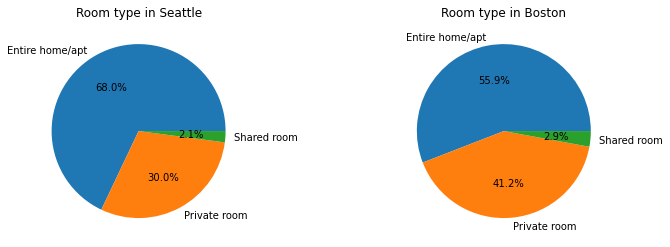

In [137]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,4))

ax1.pie(room_type_seattle.values, labels=room_type_seattle.index, autopct='%1.1f%%')
ax2.pie(room_type_boston.values, labels=room_type_boston.index, autopct='%1.1f%%')

ax1.set_title(f'Room type in Seattle')
ax2.set_title(f'Room type in Boston')

plt.show()

Hosts tended to rent out entire home/apartment as opposed to than shared / private room only in both Seattle and Boston.

### Room Price

In [138]:
# Convert price into numercial variable
host_seattle.price = convert_price_float(host_seattle.price)
host_boston.price = convert_price_float(host_boston.price)

/Users/jsuk/opt/anaconda3/envs/ds_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/jsuk/opt/anaconda3/envs/ds_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


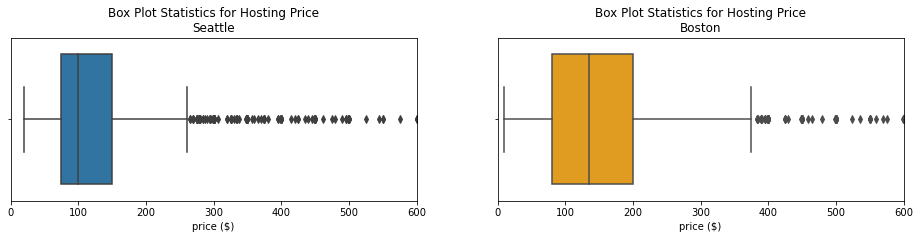

In [139]:
plt.figure(figsize=(16,3))

plt.subplot(1,2,1)
sns.boxplot(host_seattle.price)
plt.title('Box Plot Statistics for Hosting Price\nSeattle')
plt.xlabel('price ($)')
plt.xlim((0,600))

      
plt.subplot(1,2,2)
sns.boxplot(host_boston.price, color='orange')
plt.title('Box Plot Statistics for Hosting Price\nBoston')
plt.xlabel('price ($)')
plt.xlim((0,600))

plt.show()

Room price range is wider in Boston than Seattle. The median room price is also higher in Boston.

---
## `3.` How does the listing and price vary across neighborhood?

In [140]:
cols_neighbor = [
    'id', 'neighborhood_overview', 'street', 'neighbourhood', 'neighbourhood_cleansed', 
    'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 
    'smart_location', 'country_code', 'country', 'latitude', 'longitude',
    'is_location_exact', 'property_type', 'room_type', 'accommodates',
    'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 
    'availability_30', 'availability_60', 'availability_90', 
    'availability_365'
]

In [141]:
neighbor_seattle_temp = listings_sea[cols_neighbor].copy()
neighbor_boston_temp = listings_bos[cols_neighbor].copy()

### Data cleaning

In [142]:
def wrangle_airbnb_neighbor_data(df) :
    
    print(f'Original dataframe: {df.shape}')
    
    df_clean = df.copy()
    
    isDuplicated = df_clean.duplicated(subset=['id'], keep=False).sum()
    if( isDuplicated != 0 ) :
        df_clean = df_clean.drop_duplicates(subset=['id'], keep='last')
        
    df_clean.price = convert_price_float(df_clean.price)
    
    print(f'Cleaned dataframe: {df.shape}')
    
    return df_clean

In [143]:
neighbor_seattle = wrangle_airbnb_neighbor_data(neighbor_seattle_temp)
neighbor_boston = wrangle_airbnb_neighbor_data(neighbor_boston_temp)

Original dataframe: (3818, 30)
Cleaned dataframe: (3818, 30)
Original dataframe: (3585, 30)
Cleaned dataframe: (3585, 30)


### GeoPandas mapping
`geodata` folder contains shape files for Seattle and Boston

Reference: [GeoPandas 101: Plot any data with a latitude and longitude on a map](https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972)
  
Data source: 
- [City of Seattle](https://data-seattlecitygis.opendata.arcgis.com/datasets/city-clerk-neighborhoods)
- [Boston GIS](https://bostonopendata-boston.opendata.arcgis.com/datasets/3525b0ee6e6b427f9aab5d0a1d0a1a28_0)

In [144]:
# Load shape files
seattle_map = gpd.read_file('geodata/seattle/City_Clerk_Neighborhoods.shp')
boston_map = gpd.read_file('geodata/boston/Boston_Neighborhoods.shp')

In [145]:
# Create a list of geometry points with longitude, latitude data
geometry_seattle = create_points_geometry(neighbor_seattle['longitude'], neighbor_seattle['latitude'])
geometry_boston = create_points_geometry(neighbor_boston['longitude'], neighbor_boston['latitude'])

In [146]:
# Create GeoDataFrame and set coordinates reference system (crs)
gdf_seattle = gpd.GeoDataFrame(neighbor_seattle, geometry = geometry_seattle)
gdf_boston = gpd.GeoDataFrame(neighbor_boston, geometry = geometry_boston)

In [147]:
# Additional feature 'geometry' added onto the original dataframes 
gdf_seattle.geometry[:2], gdf_boston.geometry[:2]

(0    POINT (-122.37103 47.63629)
 1    POINT (-122.36567 47.63912)
 Name: geometry, dtype: geometry,
 0    POINT (-71.13307 42.28262)
 1    POINT (-71.13437 42.28624)
 Name: geometry, dtype: geometry)

### Creating 4 price categories for visualization
Based on 5 number statistics (quartiles) 

Terminology :
- $\text{\$\$\$\$}$  :  Top 25%
- $\text{\$\$\$}$ :  Top 25% - 50%
- $\text{\$\$}$ :  Bottom 25% - 50%
- $\text{\$}$ :  Bottom 25%

In [234]:
seattle_price_bins = gdf_seattle.price.describe()[3:]

seattle_price_group = pd.cut(x=gdf_seattle.price, bins=seattle_price_bins.values, 
                             labels=['\$', '\$\$', '\$\$\$', '\$\$\$\$'])

gdf_seattle['price_group'] = seattle_price_group

### Visualization and exploration

In [240]:
# To create texts index for top priced neighorhoods 
neighbor_sea = gdf_seattle.groupby('neighbourhood_cleansed').mean()
lat_lng_sea = neighbor_sea[['latitude', 'longitude', 'price']].sort_values(by='price', ascending=False)

In [241]:
price_summary_sea = lat_lng_sea.price.describe()[3:]
price_summary_sea

min     68.555556
25%     95.950928
50%    121.800000
75%    142.704082
max    231.705882
Name: price, dtype: float64

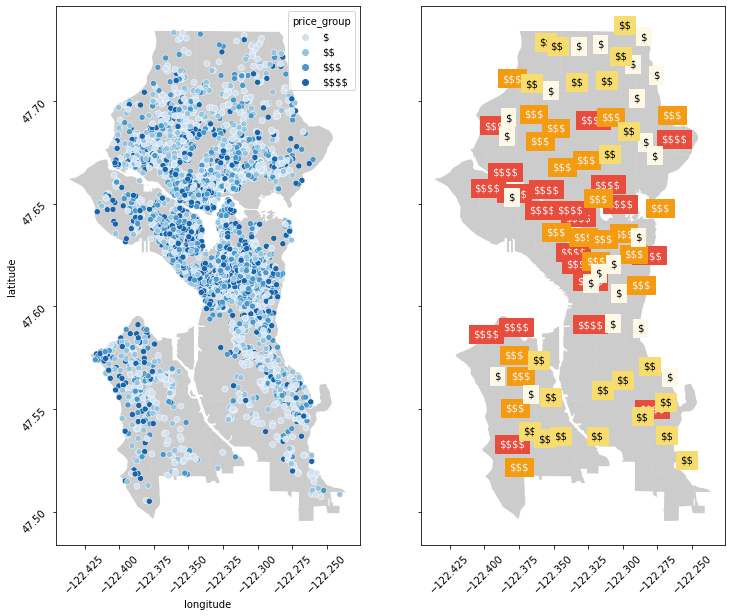

In [293]:
fig, (ax1, ax2) = plt.subplots(figsize=(12,16), ncols=2, sharey=True)

# Left plot
seattle_map.plot(ax=ax1, alpha=0.4, color='grey')
sns.scatterplot(data=gdf_seattle, x='longitude', y='latitude', hue='price_group', 
                palette='Blues', ax=ax1)

# Right plot 
seattle_map.plot(ax=ax2, alpha=0.4, color='grey')
for i, values in enumerate(lat_lng_sea.itertuples()) :
    index, lat, lng, price = values
        
    # Tag $$$$ if > 3rd quartile
    if price > price_summary_sea[3]: 
        plt.text(x=lng, y=lat+0.01, s='\$\$\$\$', backgroundcolor='#E74C3C', color='#f3f3f3')

    elif price > price_summary_sea[2] : # > median 
        plt.text(x=lng, y=lat+0.01, s='\$\$\$', backgroundcolor='#F39C12', color='#f3f3f3')
    
    elif price < price_summary_sea[1] : # > 2nd quartile
        plt.text(x=lng, y=lat+0.01, s='\$\$', backgroundcolor='#F7DC6F')
        
    else:
        plt.text(x=lng, y=lat+0.01, s='\$', backgroundcolor='#FEF9E7')

ax1.tick_params(labelrotation=45)
ax2.tick_params(labelrotation=45)
plt.show()

### Plotting Boston price distribution

In [ ]:
boston_price_bins = gdf_boston.price.describe()[3:]

boston_price_group = pd.cut(x=gdf_boston.price, bins=boston_price_bins.values, 
                             labels=['\$', '\$\$', '\$\$\$', '\$\$\$\$'])

gdf_boston['price_group'] = boston_price_group

In [270]:
# To create texts index for top priced neighorhoods 
neighbor_bos = gdf_boston.groupby('neighbourhood_cleansed').mean()
lat_lng_bos = neighbor_bos[['latitude', 'longitude', 'price']].sort_values(by='price', ascending=False)
price_summary_bos = lat_lng_bos.price.describe()[3:]

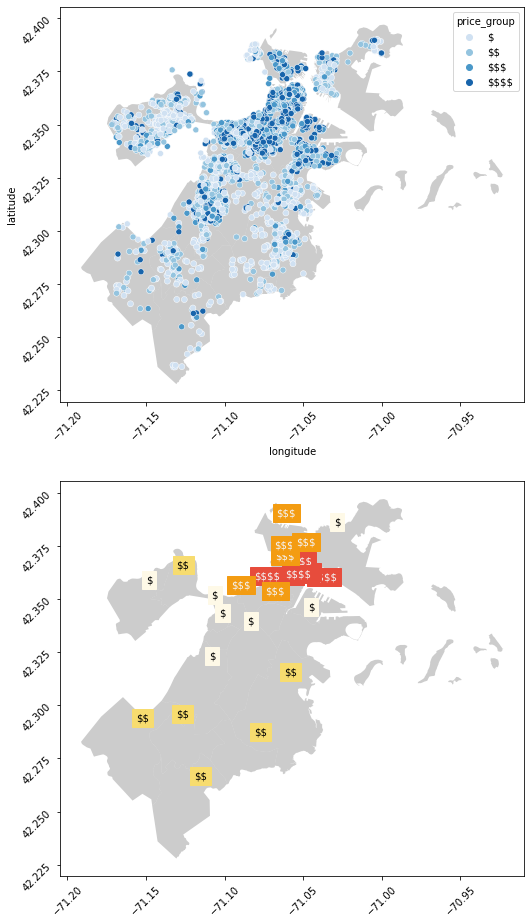

In [291]:
fig, (ax1, ax2) = plt.subplots(figsize=(16,16), nrows=2)

# Left plot
boston_map.plot(ax=ax1, alpha=0.4, color='grey')
sns.scatterplot(data=gdf_boston, x='longitude', y='latitude', hue='price_group', 
                palette='Blues', ax=ax1)

# Right plot 
boston_map.plot(ax=ax2, alpha=0.4, color='grey')

for i, values in enumerate(lat_lng_bos.itertuples()) :
    index, lat, lng, price = values

    if price > price_summary_bos[3]: 
        plt.text(x=lng, y=lat+0.01, s='\$\$\$\$', backgroundcolor='#E74C3C', color='#f3f3f3')

    elif price > price_summary_bos[2] : # > median 
        plt.text(x=lng, y=lat+0.01, s='\$\$\$', backgroundcolor='#F39C12', color='#f3f3f3')
    
    elif price < price_summary_bos[1] : # > 2nd quartile
        plt.text(x=lng, y=lat+0.01, s='\$\$', backgroundcolor='#F7DC6F')
        
    else:
        plt.text(x=lng, y=lat+0.01, s='\$', backgroundcolor='#FEF9E7')

ax1.tick_params(labelrotation=45)
ax2.tick_params(labelrotation=45)
plt.show()

---
<a id="bottom"></a>
[Go to the top](#top)

<a id="function"></a>
[Go to functions](#function)